>>> Initializing Experiment on cpu...


100%|██████████| 9.91M/9.91M [00:00<00:00, 137MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 38.8MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 74.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.56MB/s]


>>> Loaded Real MNIST Image: Class 6

[1/3] Running Scenario: No-DP (Standard FL)
   -> Optimizing reconstruction...

[2/3] Running Scenario: PrivateFL (Linear Transform + DP)
   -> Optimizing reconstruction...

[3/3] Running Scenario: MIC (Non-Linear Transform + DP)
   -> Optimizing reconstruction...

>>> Visualizing Reconstruction Progression...


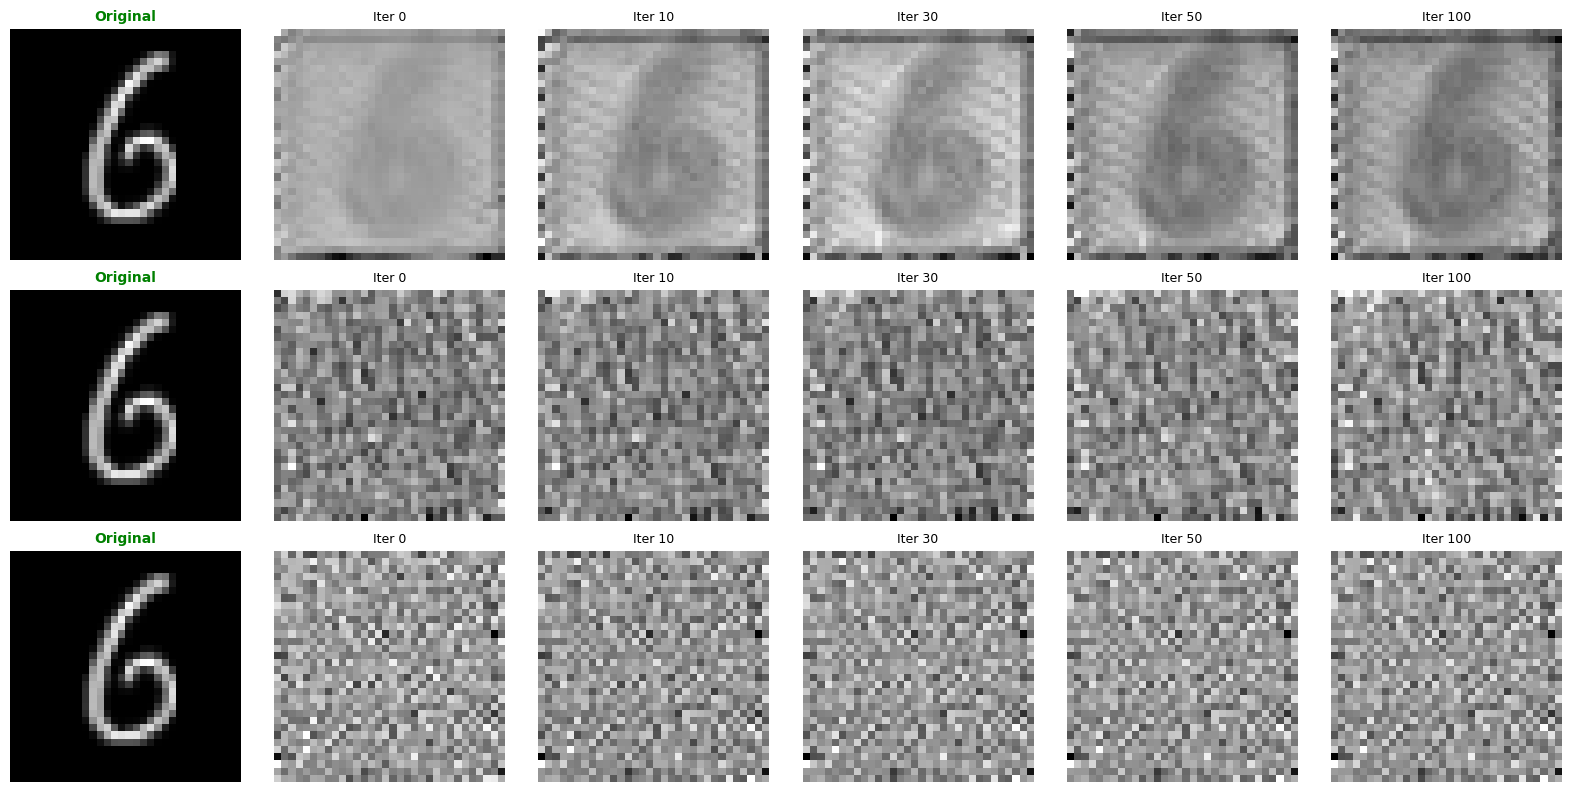

In [ ]:
# @title PrivateFL vs MIC vs No-DP: Attack Reconstruction with Ground Truth
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import copy

# ==========================================
# 1. Configuration & Helper Classes
# ==========================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

print(f">>> Initializing Experiment on {DEVICE}...")

# --- A. Transformation Layers ---

# 1. PrivateFL: Linear Transformation (alpha*x + beta)
# The paper proposes this as the optimal transformation for privacy/utility balance
class LinearTransform(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
    def forward(self, x):
        return x * self.alpha + self.beta

# 2. MIC-based: Non-Linear Transformation
# Represents methods using complex/non-linear mappings
class MICTransform(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.Tanh() # Non-linear activation makes reconstruction harder/different
        )
    def forward(self, x):
        return self.conv(x)

# --- B. The Victim Model (LeNet-like) ---
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(48 * 32 * 32, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

# ==========================================
# 2. Data Loading (Actual MNIST Data)
# ==========================================
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download Real Data
try:
    data_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    # Pick a specific image (Index 18 is usually a clear '6' or '3')
    target_img, target_label = data_train[18]
    target_img = target_img.unsqueeze(0).to(DEVICE)
    target_label = torch.tensor([target_label]).to(DEVICE)
    print(f">>> Loaded Real MNIST Image: Class {target_label.item()}")
except:
    print(">>> Error loading data, falling back to noise.")
    target_img = torch.randn(1, 1, 32, 32).to(DEVICE)
    target_label = torch.tensor([0]).to(DEVICE)

# ==========================================
# 3. Gradient Calculation & Attack Logic
# ==========================================

def compute_gradients(transform_layer, apply_dp=False):
    """
    Computes gradients for the given setup.
    If apply_dp is True, adds noise and clips (PrivateFL mechanism).
    """
    model = LeNet().to(DEVICE)

    # Init transformation
    if transform_layer is not None:
        transform_layer = transform_layer.to(DEVICE)
        transform_layer.train()

    # Forward Pass
    if transform_layer:
        x_input = transform_layer(target_img)
    else:
        x_input = target_img

    pred = model(x_input)
    loss = F.cross_entropy(pred, target_label)

    # Compute Gradients
    # We attack the MODEL gradients (as those are shared in FL)
    grads = torch.autograd.grad(loss, model.parameters())
    grads = [g.detach().clone() for g in grads]

    # Apply Differential Privacy (DP-SGD)
    if apply_dp:
        # 1. Clip
        clip_threshold = 1.0
        total_norm = torch.norm(torch.stack([torch.norm(g) for g in grads]))
        clip_coef = clip_threshold / (total_norm + 1e-6)
        if clip_coef < 1:
            grads = [g * clip_coef for g in grads]

        # 2. Add Noise (Using Epsilon=8.0 settings from Paper Table 3)
        # Noise scale approx 0.1 for reasonable utility/privacy balance demo
        noise_scale = 0.1
        grads = [g + torch.randn_like(g) * noise_scale for g in grads]

    return grads

def reconstruct(target_grads):
    """
    Algorithm 1 from Gradient Leakage Paper.
    Reconstructs image from gradients.
    """
    # Start from random noise
    dummy_img = torch.randn(1, 1, 32, 32, requires_grad=True, device=DEVICE)
    optimizer = torch.optim.LBFGS([dummy_img], lr=1.0, max_iter=20)

    history_imgs = []

    # Store images at specific iterations [0, 10, 30, 50, 99]
    capture_iters = [0, 10, 30, 50, 99]

    print("   -> Optimizing reconstruction...")
    model = LeNet().to(DEVICE)
    model.eval()

    for i in range(100):
        def closure():
            optimizer.zero_grad()
            dummy_pred = model(dummy_img)
            dummy_loss = F.cross_entropy(dummy_pred, target_label)
            dummy_grads = torch.autograd.grad(dummy_loss, model.parameters(), create_graph=True)

            grad_diff = 0
            for gx, gy in zip(dummy_grads, target_grads):
                grad_diff += ((gx - gy) ** 2).sum()
            grad_diff.backward()
            return grad_diff

        optimizer.step(closure)

        if i in capture_iters:
            # Denormalize for display
            img_disp = dummy_img.detach().cpu().squeeze().numpy()
            img_disp = (img_disp * 0.5) + 0.5
            history_imgs.append(img_disp)

    return history_imgs

# ==========================================
# 4. Run Experiment: 3 Scenarios
# ==========================================

# Scenario 1: No-DP
print("\n[1/3] Running Scenario: No-DP (Standard FL)")
grads_nodp = compute_gradients(None, apply_dp=False)
imgs_nodp = reconstruct(grads_nodp)

# Scenario 2: PrivateFL (Linear Transform + DP)
print("\n[2/3] Running Scenario: PrivateFL (Linear Transform + DP)")
tf_linear = LinearTransform((1, 32, 32))
grads_pfl = compute_gradients(tf_linear, apply_dp=True)
imgs_pfl = reconstruct(grads_pfl)

# Scenario 3: MIC Replacement (Non-Linear Transform + DP)
print("\n[3/3] Running Scenario: MIC (Non-Linear Transform + DP)")
tf_mic = MICTransform(1)
grads_mic = compute_gradients(tf_mic, apply_dp=True)
imgs_mic = reconstruct(grads_mic)

# ==========================================
# 5. Visualization (Reconstruction Progression)
# ==========================================
print("\n>>> Visualizing Reconstruction Progression...")

def plot_row(ax_row, img_list, title):
    # Prepare Ground Truth Image
    gt_img = target_img.detach().cpu().squeeze().numpy()
    gt_img = (gt_img * 0.5) + 0.5 # Denormalize

    # Plot Original (Column 0)
    ax_row[0].imshow(gt_img, cmap='gray')
    ax_row[0].set_title("Original", fontsize=10, color='green', fontweight='bold')
    ax_row[0].axis('off')

    # Set Row Label
    ax_row[0].set_ylabel(title, rotation=0, labelpad=80, fontsize=12, fontweight='bold')

    # Plot Reconstructions (Columns 1-5)
    iters = [0, 10, 30, 50, 100]
    for i, img_data in enumerate(img_list):
        ax_col = i + 1
        ax_row[ax_col].imshow(img_data, cmap='gray')
        ax_row[ax_col].set_title(f"Iter {iters[i]}", fontsize=9)
        ax_row[ax_col].axis('off')

# Create 3 rows x 6 columns (1 Original + 5 Iterations)
fig, axes = plt.subplots(3, 6, figsize=(16, 8))

# Row 1: No-DP
plot_row(axes[0], imgs_nodp, "No-DP\n(Vulnerable)")

# Row 2: PrivateFL
plot_row(axes[1], imgs_pfl, "PrivateFL\n(Protected)")

# Row 3: MIC
plot_row(axes[2], imgs_mic, "MIC Method\n(Protected)")

plt.tight_layout()
plt.show()

>>> Initializing Experiment on cpu...
>>> Loaded Real MNIST Image: Class 6

[1/3] No-DP Scenario
   -> Optimizing for 200 iterations...

[2/3] PrivateFL (Linear) Scenario
   -> Optimizing for 200 iterations...

[3/3] MIC (Non-Linear) Scenario
   -> Optimizing for 200 iterations...

>>> Visualizing Results...


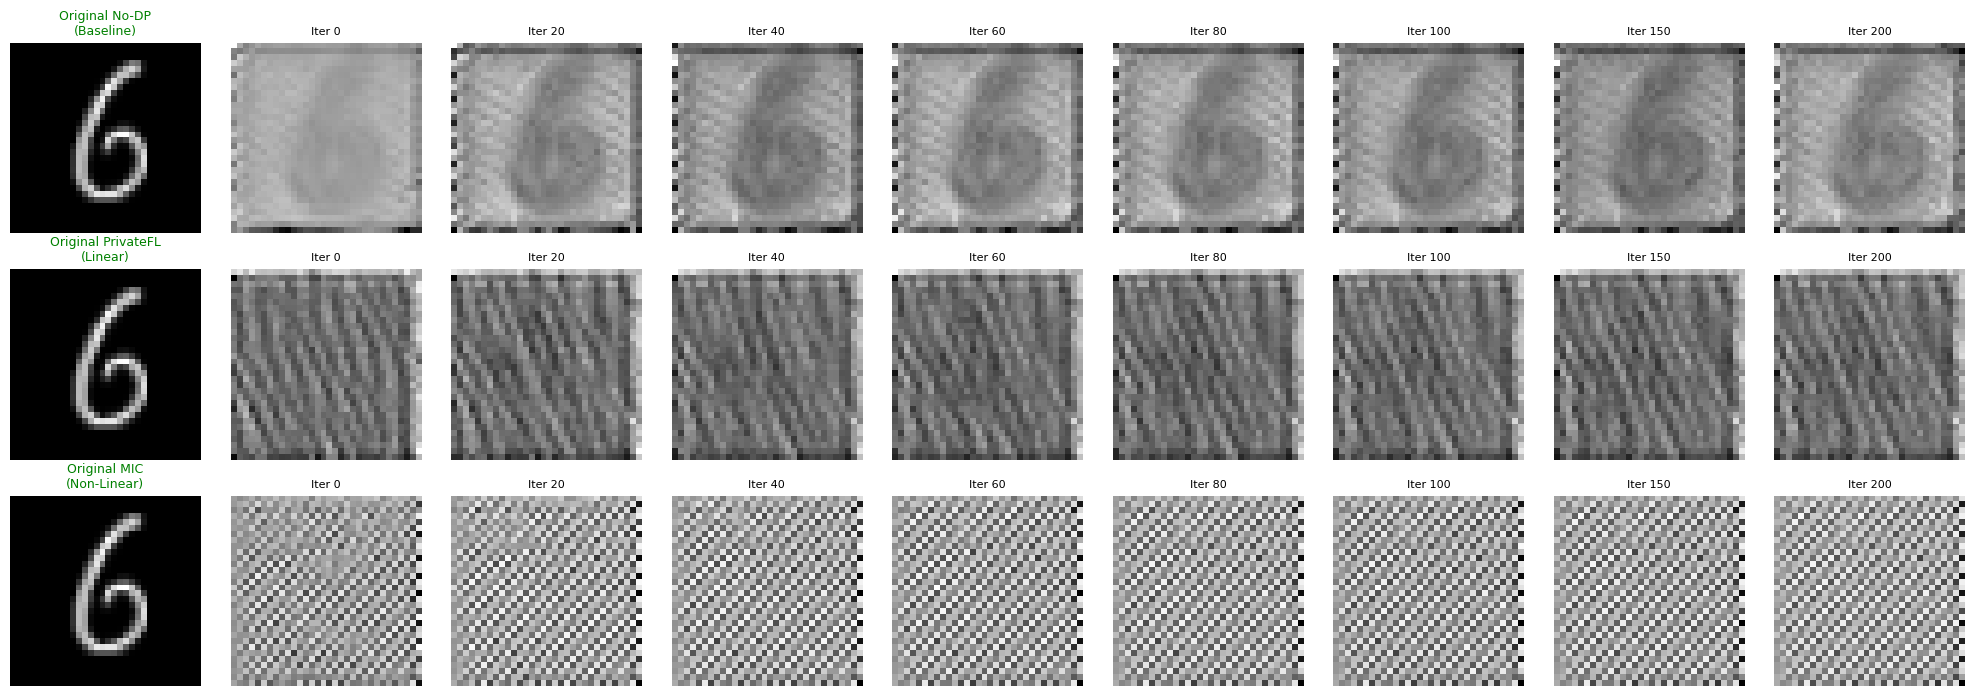

In [ ]:
# @title Attack Demo: Low Noise & Extended Iterations
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import copy

# ==========================================
# 1. Configuration
# ==========================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

# --- KEY CHANGES FOR YOU ---
NOISE_SCALE = 0.0001  # Extremely low noise
TOTAL_ITERS = 200     # More iterations for better convergence
CAPTURE_ITERS = [0, 20, 40, 60, 80, 100, 150, 200] # More snapshots
# ---------------------------

print(f">>> Initializing Experiment on {DEVICE}...")

# ==========================================
# 2. Models & Transforms
# ==========================================

# A. PrivateFL: Linear Transformation (alpha*x + beta)
class LinearTransform(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
    def forward(self, x):
        return x * self.alpha + self.beta

# B. MIC Replacement: Non-Linear Transform (Conv+Tanh)
class MICTransform(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        return self.conv(x)

# C. Victim Model (LeNet)
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(48 * 32 * 32, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

# ==========================================
# 3. Data Loading
# ==========================================
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

try:
    data_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    target_img, target_label = data_train[18] # Index 18 is a '6'
    target_img = target_img.unsqueeze(0).to(DEVICE)
    target_label = torch.tensor([target_label]).to(DEVICE)
    print(f">>> Loaded Real MNIST Image: Class {target_label.item()}")
except:
    target_img = torch.randn(1, 1, 32, 32).to(DEVICE)
    target_label = torch.tensor([0]).to(DEVICE)

# ==========================================
# 4. Attack Logic
# ==========================================

def compute_gradients(transform_layer, apply_dp=False):
    model = LeNet().to(DEVICE)
    if transform_layer:
        transform_layer = transform_layer.to(DEVICE)
        transform_layer.train()
        x_input = transform_layer(target_img)
    else:
        x_input = target_img

    pred = model(x_input)
    loss = F.cross_entropy(pred, target_label)

    grads = torch.autograd.grad(loss, model.parameters())
    grads = [g.detach().clone() for g in grads]

    if apply_dp:
        # DP-SGD Mechanism with REDUCED noise
        clip_threshold = 1.0
        total_norm = torch.norm(torch.stack([torch.norm(g) for g in grads]))
        clip_coef = clip_threshold / (total_norm + 1e-6)
        if clip_coef < 1:
            grads = [g * clip_coef for g in grads]

        # Add tiny noise (as requested)
        grads = [g + torch.randn_like(g) * NOISE_SCALE for g in grads]

    return grads

def reconstruct(target_grads):
    dummy_img = torch.randn(1, 1, 32, 32, requires_grad=True, device=DEVICE)
    optimizer = torch.optim.LBFGS([dummy_img], lr=1.0, max_iter=20)

    history_imgs = []

    print(f"   -> Optimizing for {TOTAL_ITERS} iterations...")
    model = LeNet().to(DEVICE)
    model.eval()

    for i in range(TOTAL_ITERS + 1):
        def closure():
            optimizer.zero_grad()
            dummy_pred = model(dummy_img)
            dummy_loss = F.cross_entropy(dummy_pred, target_label)
            dummy_grads = torch.autograd.grad(dummy_loss, model.parameters(), create_graph=True)

            grad_diff = 0
            for gx, gy in zip(dummy_grads, target_grads):
                grad_diff += ((gx - gy) ** 2).sum()
            grad_diff.backward()
            return grad_diff

        optimizer.step(closure)

        if i in CAPTURE_ITERS:
            img_disp = dummy_img.detach().cpu().squeeze().numpy()
            img_disp = (img_disp * 0.5) + 0.5
            history_imgs.append(img_disp)

    return history_imgs

# ==========================================
# 5. Run Experiments
# ==========================================

# 1. No-DP
print("\n[1/3] No-DP Scenario")
grads_nodp = compute_gradients(None, apply_dp=False)
imgs_nodp = reconstruct(grads_nodp)

# 2. PrivateFL (Linear)
print("\n[2/3] PrivateFL (Linear) Scenario")
tf_linear = LinearTransform((1, 32, 32))
grads_pfl = compute_gradients(tf_linear, apply_dp=True)
imgs_pfl = reconstruct(grads_pfl)

# 3. MIC (Non-Linear)
print("\n[3/3] MIC (Non-Linear) Scenario")
tf_mic = MICTransform(1)
grads_mic = compute_gradients(tf_mic, apply_dp=True)
imgs_mic = reconstruct(grads_mic)

# ==========================================
# 6. Visualization
# ==========================================
print("\n>>> Visualizing Results...")

def plot_row(ax_row, img_list, title):
    # Original GT
    gt_img = target_img.detach().cpu().squeeze().numpy()
    gt_img = (gt_img * 0.5) + 0.5

    ax_row[0].imshow(gt_img, cmap='gray')
    ax_row[0].set_title(f"Original {title}", fontsize=9, color='green')
    ax_row[0].axis('off')
    ax_row[0].set_ylabel(title, rotation=0, labelpad=60, fontsize=11, fontweight='bold')

    # Iterations
    for i, img_data in enumerate(img_list):
        ax_col = i + 1
        ax_row[ax_col].imshow(img_data, cmap='gray')
        ax_row[ax_col].set_title(f"Iter {CAPTURE_ITERS[i]}", fontsize=8)
        ax_row[ax_col].axis('off')

# 3 Rows x (1 Original + 8 Snapshots) = 9 Cols
fig, axes = plt.subplots(3, 9, figsize=(20, 7))

plot_row(axes[0], imgs_nodp, "No-DP\n(Baseline)")
plot_row(axes[1], imgs_pfl, "PrivateFL\n(Linear)")
plot_row(axes[2], imgs_mic, "MIC\n(Non-Linear)")

plt.tight_layout()
plt.show()
